In [1]:
%load_ext nb_black
%matplotlib inline
from IPython.display import set_matplotlib_formats
import matplotlib.pyplot as plt
import numpy as np
import logging
import jax


logging.getLogger().setLevel(logging.INFO)
logging.getLogger("absl").setLevel(logging.DEBUG)

set_matplotlib_formats("svg")


<IPython.core.display.Javascript object>

In [2]:
from math import log, exp
from sim import sim_and_fit, sim_wf
from common import Observation
from plotting import plot_summary
rng = np.random.default_rng(2)


DEBUG:absl:Initializing backend 'interpreter'
DEBUG:absl:Initializing backend 'cpu'
DEBUG:absl:Initializing backend 'gpu'
DEBUG:absl:Error initializing backend 'gpu': Not found: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
DEBUG:absl:Initializing backend 'tpu'
DEBUG:absl:Error initializing backend 'tpu': Invalid argument: TpuPlatform is not available.


<IPython.core.display.Javascript object>

## Various models
(Note: for technical reasons estimation currently requires genic selection. The `h` parameter can still be used to simulate non-genic selection, but `h=0.5` is assumed during inference.)

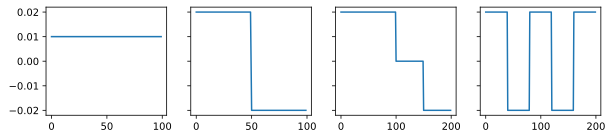

<IPython.core.display.Javascript object>

In [3]:
mdls = [
    {"s": [0.01] * 100, "h": [0.5] * 100, "f0": 0.1},
    {"s": [0.02] * 50 + [-0.02] * 50, "h": [0.5] * 100, "f0": 0.1},
    {"s": [0.02] * 100 + [0.0] * 50 + [-0.02] * 50, "h": [0.5] * 200, "f0": 0.1},
    {"s": (([0.02] * 40 + [-0.02] * 40) * 3)[:200], "h": [0.5] * 200, "f0": 0.5},
]
model = mdls[1]
for m, ax in zip(mdls, plt.subplots(ncols=len(mdls), figsize=(10, 2), sharey=True)[1]):
    ax.plot(np.arange(len(m["s"])), m["s"])

In [4]:
%%time
## First call to JIT (slow)
# jax.config.update('jax_debug_nans', 1)
sim_and_fit(mdls[1], seed=2, lam=1e2)
None

DEBUG:absl:Compiling _obj (5543126144) for args (ShapedArray(float64[100]), ShapedArray(float64[100]), ShapedArray(float64[101,2]), ShapedArray(float64[], weak_type=True)).


CPU times: user 6.53 s, sys: 139 ms, total: 6.67 s
Wall time: 6.68 s


<IPython.core.display.Javascript object>

In [5]:
%%time
## Subsequent calls (fast)
sim_and_fit(mdls[1], seed=2, lam=1e1)
None

CPU times: user 293 ms, sys: 11.1 ms, total: 304 ms
Wall time: 302 ms


<IPython.core.display.Javascript object>

In [ ]:
%%time
model = mdls[1]
res = []
for seed in range(100):
    res.append(sim_and_fit(model, seed=seed, lam=1e2, n=100))

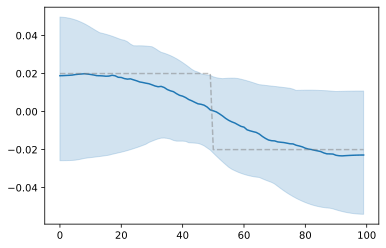

<IPython.core.display.Javascript object>

In [14]:
plot_summary(
    plt.gca(),
    [tuple(range(len(res[0]["s_hat"])))],
    np.array([r["s_hat"] for r in res]),
    model["s"],
)

## Sample from posterior

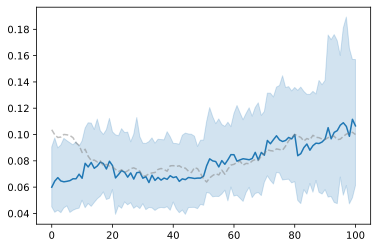

<IPython.core.display.Javascript object>

In [18]:
from betamix import sample_paths

r = res[0]
paths = sample_paths(r["s_hat"], r["Ne"], r["obs"], k=100, M=100)
x = tuple(range(len(r["true_af"])))
plot_summary(plt.gca(), [x], paths, r["true_af"])